In [1]:
#Link: https://www.analyticsvidhya.com/blog/2016/08/practicing-machine-learning-techniques-in-r-with-mlr-package/
#This tutorial will show how to use mlr library
#mlr is like python skitlearn, it's a library that bundle all necessary tools for ml projects

In [2]:
#In this tutorial we will use mlr to create model to predict give loan to applicant using applicants information

In [3]:
#Import mlr package
library(mlr)
library(XML)
library(dplyr)

Loading required package: ParamHelpers

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
#getting data
train <- read.csv("dataset/train_loan.csv", na.string = c("", " ", NA))
test <- read.csv('dataset/test_loan.csv', na.strings = c("", " ", NA))

In [5]:
#Explore train set
head(train, 5)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
LP001002,Male,No,0,Graduate,No,5849,0,NA,360,1,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y


In [6]:
summarizeColumns(train)

name,type,na,mean,disp,median,mad,min,max,nlevs
Loan_ID,factor,0,NA,0.9983713,NA,NA,1,1,614
Gender,factor,13,NA,NA,NA,NA,112,489,2
Married,factor,3,NA,NA,NA,NA,213,398,2
Dependents,factor,15,NA,NA,NA,NA,51,345,4
Education,factor,0,NA,0.2182410,NA,NA,134,480,2
Self_Employed,factor,32,NA,NA,NA,NA,82,500,2
ApplicantIncome,integer,0,5403.4592834,6109.0416734,3812.5,1822.8567,150,81000,0
CoapplicantIncome,numeric,0,1621.2457980,2926.2483692,1188.5,1762.0701,0,41667,0
LoanAmount,integer,22,146.4121622,85.5873252,128.0,47.4432,9,700,0
Loan_Amount_Term,integer,14,342.0000000,65.1204099,360.0,0.0000,12,480,0


In [7]:
#Credit_History is integer with only 2 possible values, 0 and 1 that we should convert to factor
#Credit_History has mean of 0.84 which means about 84% of applicants have credit history

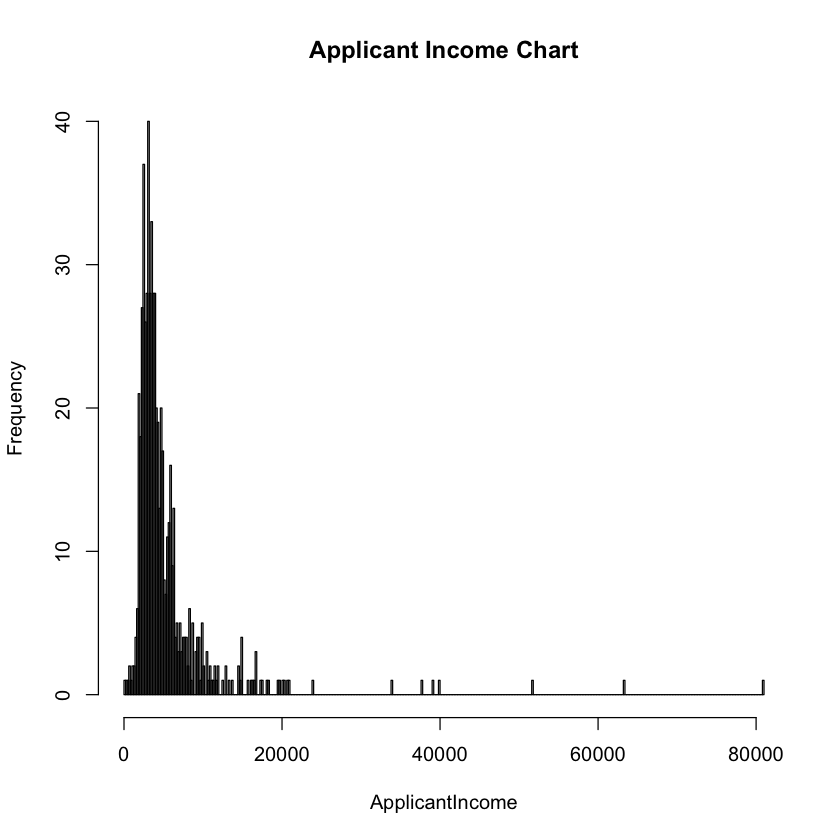

In [8]:
#Plotting Histogram of numberic columns
hist(train$ApplicantIncome, breaks = 300, xlab = 'ApplicantIncome', main = 'Applicant Income Chart')

In [9]:
#ApplicantIncome are serverly skewed we have to normalize them

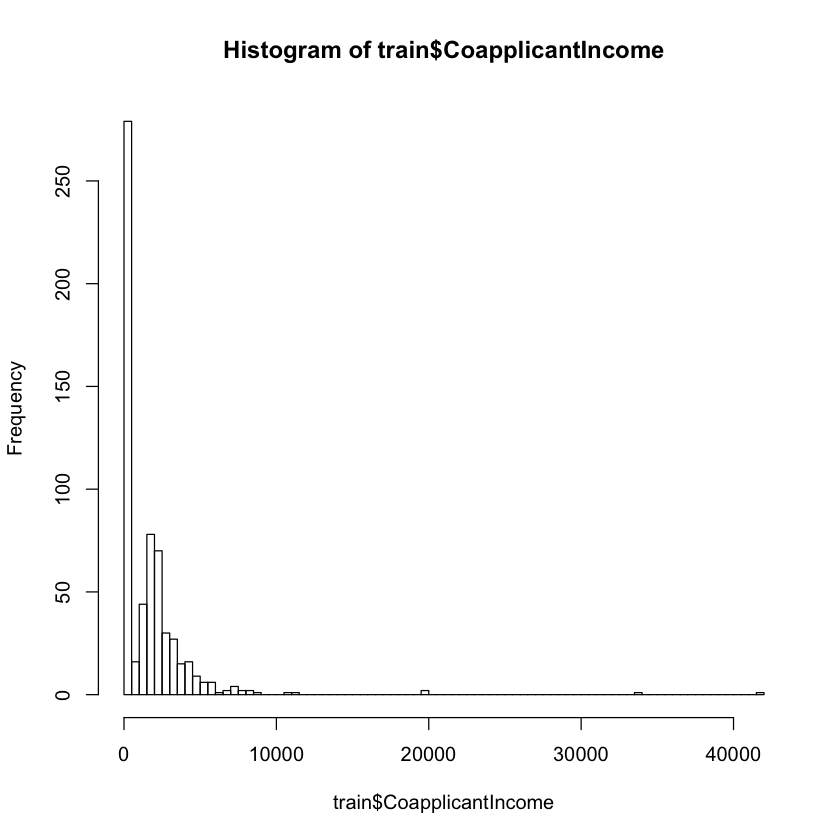

In [10]:
hist(train$CoapplicantIncome, breaks = 100 )

In [11]:
#CoapplicantIncome are also skewed we have to normalize them, and most of them are 0s mean many of Coapplicants have no income

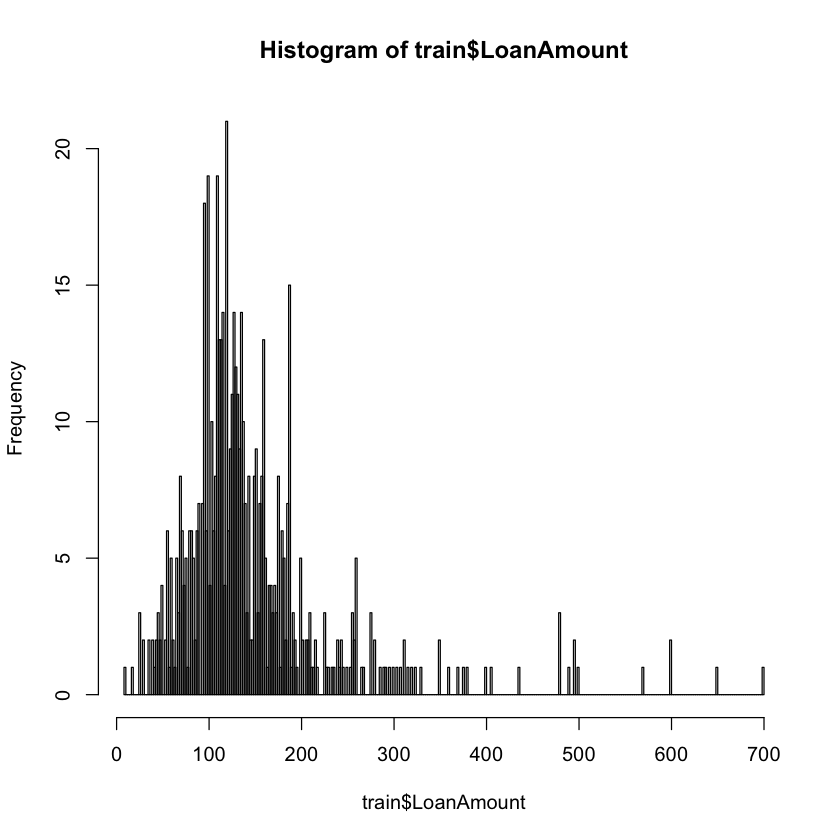

In [12]:
hist(train$LoanAmount, breaks = 300)

In [13]:
#LoanAmount seems normalized at 0 to 300, 
#but also many of them are beyond 300 we can't considerate them (>300) as outlier yet (since they have a significant number)

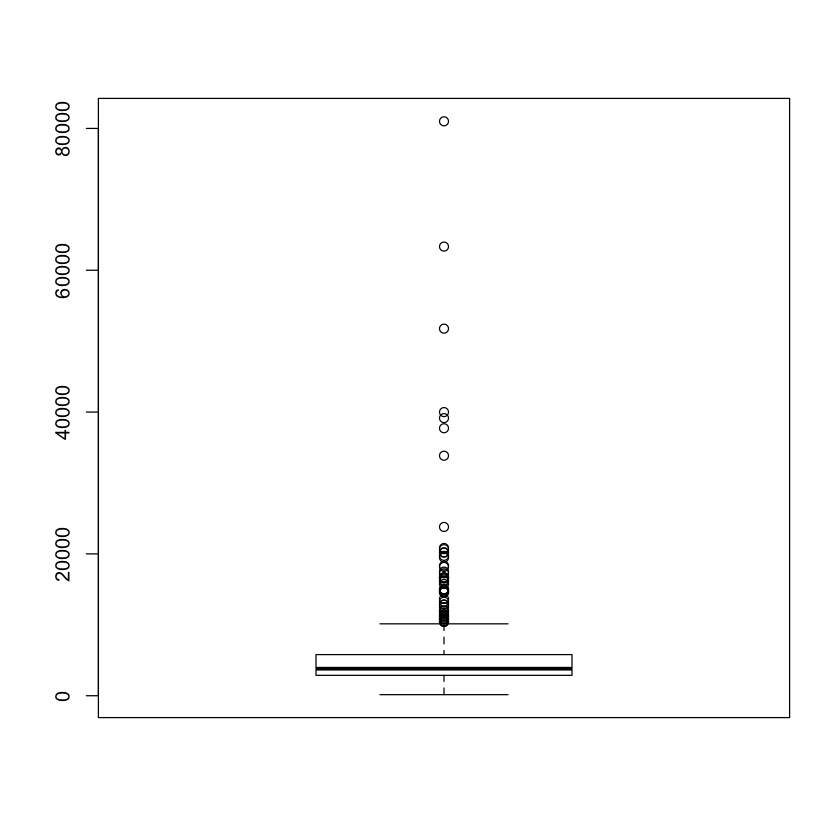

In [14]:
#Let's visualize outliers

#ApplicantIncome
boxplot(train$ApplicantIncome)

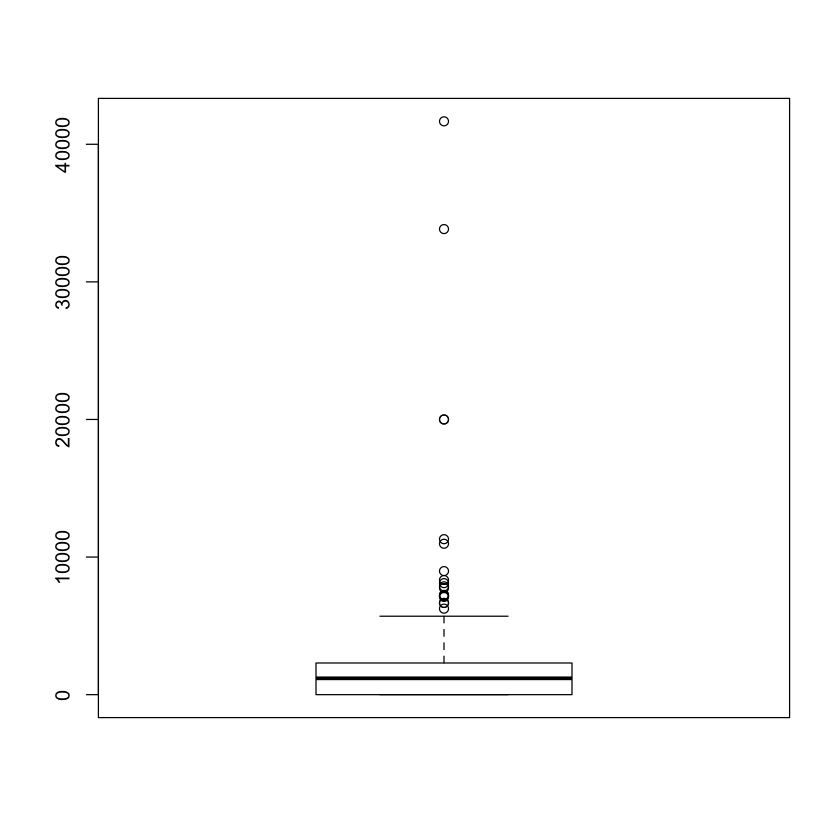

In [15]:
#CoapplicantIncome
boxplot(train$CoapplicantIncome)

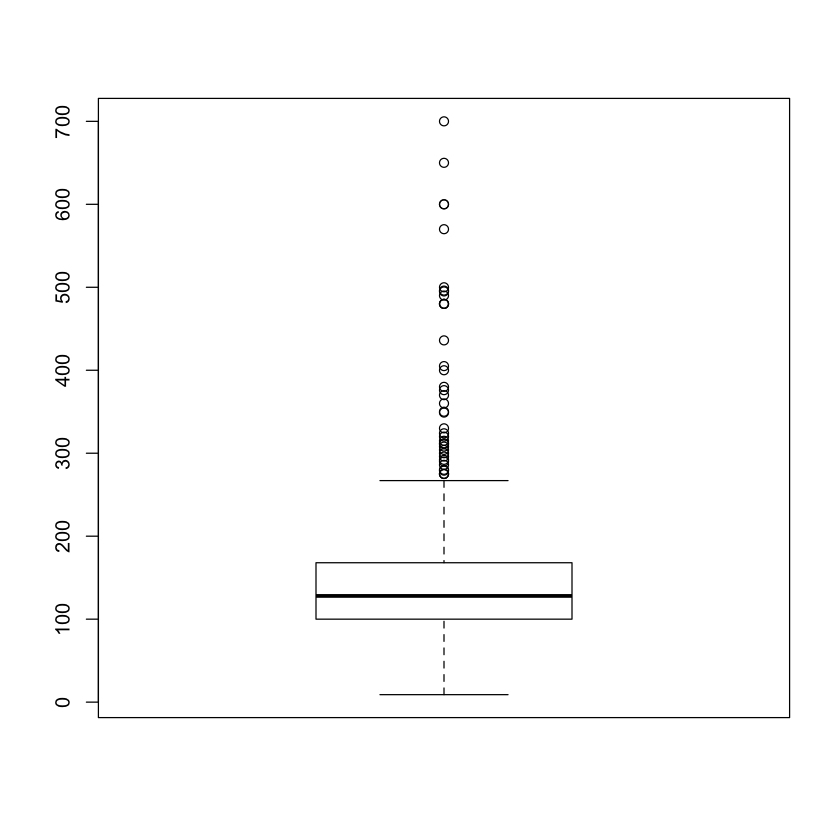

In [16]:
boxplot(train$LoanAmount)

In [17]:
#seems like ApplicantIncome, CoapplicantIncome and LoanAmount have outliers which we have to handle later

In [18]:
#let's explore categorical variables
table(train$Gender)


Female   Male 
   112    489 

In [19]:
table(train$Married)


 No Yes 
213 398 

In [20]:
table(train$Dependents)


  0   1   2  3+ 
345 102 101  51 

In [21]:
#should convert '3+' to '3'

In [22]:
table(train$Self_Employed)


 No Yes 
500  82 

In [23]:
table(train$Education)


    Graduate Not Graduate 
         480          134 

In [24]:
table(train$Loan_Status)


  N   Y 
192 422 

In [25]:
#After we do exploration we have few things to do before we go to next step
#1. we have to convert Credit_History to factor
#2. we have to convert Dependents level '3+' to '3'
#3. we have to handle na values
#4. we have to handle outliers value

In [26]:
#convert Credit_History to factor
train$Credit_History <- as.factor(train$Credit_History)
test$Credit_History <- as.factor(test$Credit_History)

In [27]:
#convert Dependents '3+' to '3'
levels(train$Dependents)[4] <- '3'
levels(test$Dependents)[4] <- '3'

levels(train$Dependents)

[1] "0" "1" "2" "3"

In [28]:
#Next, we handle na values by imputing integer variable with mean and imputing categorical variables with median
train_impute <- impute(train, classes = list(factor = imputeMode(), integer = imputeMean()), dummy.classes = c('integer','factor'), dummy.type = 'numeric')
test_impute <- impute(test, classes = list(factor = imputeMode(), integer = imputeMean()), dummy.classes = c('integer', 'factor'), dummy.type = 'numeric')
#dummy.classes parameter tells imputer to create dummy variable for each class that has missing value 
#and values of the dummy variables are 1 if the value of variable corresponding to that dummy class are missing, and 0 otherwise
train <- train_impute$data
test <- test_impute$data
head(train, 5)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Gender.dummy,Married.dummy,Dependents.dummy,Self_Employed.dummy,LoanAmount.dummy,Loan_Amount_Term.dummy,Credit_History.dummy
LP001002,Male,No,0,Graduate,No,5849,0,146.4122,360,1,Urban,Y,0,0,0,0,1,0,0
LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0000,360,1,Rural,N,0,0,0,0,0,0,0
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0000,360,1,Urban,Y,0,0,0,0,0,0,0
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0000,360,1,Urban,Y,0,0,0,0,0,0,0
LP001008,Male,No,0,Graduate,No,6000,0,141.0000,360,1,Urban,Y,0,0,0,0,0,0,0


In [29]:
head(test, 5)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender.dummy,Dependents.dummy,Self_Employed.dummy,LoanAmount.dummy,Loan_Amount_Term.dummy,Credit_History.dummy
LP001015,Male,Yes,0,Graduate,No,5720,0,110,360,1,Urban,0,0,0,0,0,0
LP001022,Male,Yes,1,Graduate,No,3076,1500,126,360,1,Urban,0,0,0,0,0,0
LP001031,Male,Yes,2,Graduate,No,5000,1800,208,360,1,Urban,0,0,0,0,0,0
LP001035,Male,Yes,2,Graduate,No,2340,2546,100,360,1,Urban,0,0,0,0,0,1
LP001051,Male,No,0,Not Graduate,No,3276,0,78,360,1,Urban,0,0,0,0,0,0


In [30]:
summarizeColumns(train)

name,type,na,mean,disp,median,mad,min,max,nlevs
Loan_ID,factor,0,NA,9.983713e-01,NA,NA,1,1,614
Gender,factor,0,NA,1.824104e-01,NA,NA,112,502,2
Married,factor,0,NA,3.469055e-01,NA,NA,213,401,2
Dependents,factor,0,NA,4.136808e-01,NA,NA,51,360,4
Education,factor,0,NA,2.182410e-01,NA,NA,134,480,2
Self_Employed,factor,0,NA,1.335505e-01,NA,NA,82,532,2
ApplicantIncome,numeric,0,5.403459e+03,6.109042e+03,3812.5,1822.8567,150,81000,0
CoapplicantIncome,numeric,0,1.621246e+03,2.926248e+03,1188.5,1762.0701,0,41667,0
LoanAmount,numeric,0,1.464122e+02,8.403747e+01,129.0,45.2193,9,700,0
Loan_Amount_Term,numeric,0,3.420000e+02,6.437249e+01,360.0,0.0000,12,480,0


In [31]:
#Next, we will handle outliers in ApplicantIncome, CoapplicantIncome and Loan_Amount variables
#we will handle the outliers by capping them

#add dummy Loan_Status for test set
test$Loan_Status <- sample(0: 1, 367, replace = T)

#Cap ApplicantIncome
cd <- capLargeValues(train, target = "Loan_Status", cols = c("ApplicantIncome"), threshold = 40000)
cde <- capLargeValues(test, target = "Loan_Status", cols = c("ApplicantIncome"), threshold = 33000)

#cap CoapplicantIncome
cd <- capLargeValues(cd, target = "Loan_Status", cols = c("CoapplicantIncome"), threshold = 11000)
cde <- capLargeValues(cde, target = "Loan_Status",cols = c("CoapplicantIncome"), threshold = 15000)

#Cap LoanAmount
cd <- capLargeValues(cd, target = "Loan_Status", cols = c("LoanAmount"), threshold = 500)
cde <- capLargeValues(cde, target = "Loan_Status", cols = c("LoanAmount"), threshold = 350)

train_cd <- cd
test_cd <- cde

In [32]:
summarizeColumns(train_cd)
#show capped result

name,type,na,mean,disp,median,mad,min,max,nlevs
Loan_ID,factor,0,NA,9.983713e-01,NA,NA,1,1,614
Gender,factor,0,NA,1.824104e-01,NA,NA,112,502,2
Married,factor,0,NA,3.469055e-01,NA,NA,213,401,2
Dependents,factor,0,NA,4.136808e-01,NA,NA,51,360,4
Education,factor,0,NA,2.182410e-01,NA,NA,134,480,2
Self_Employed,factor,0,NA,1.335505e-01,NA,NA,82,532,2
ApplicantIncome,numeric,0,5.279518e+03,4.985851e+03,3812.5,1822.8567,150,40000,0
CoapplicantIncome,numeric,0,1.504301e+03,1.924230e+03,1188.5,1762.0701,0,11000,0
LoanAmount,numeric,0,1.454024e+02,7.876196e+01,129.0,45.2193,9,500,0
Loan_Amount_Term,numeric,0,3.420000e+02,6.437249e+01,360.0,0.0000,12,480,0


In [33]:
#Notice that all dummy variables are class of numeric, but their values are binary
#So, we will convert this dummies into factor

#Convert train set
for (i in names(train_cd[, c(14: 20)])) {
    if(class(train_cd[, i]) == 'numeric') {
        levels <- unique(train_cd[, i])
        train_cd[, i] <- as.factor(factor(train_cd[, i], levels = levels))
    }
}

for (i in names(test_cd[, 13:18])) {
    if(class(test_cd[, i]) == 'numeric') {
        levels = unique(test_cd[, i])
        test_cd[, i] <- as.factor(factor(test_cd[, i], levels = levels))
    }
}



In [34]:
#Next, lets create net features

#Total Income
train_cd$Totle_Income <- train_cd$ApplicantIncome + train_cd$CoapplicantIncome
test_cd$Totle_Income <- test_cd$ApplicantIncome + test_cd$CoapplicantIncome

#Loan per Income
train_cd$Loan_per_income <- train_cd$LoanAmount / train_cd$Totle_Income
test_cd$Loan_per_income <- test_cd$LoanAmount / test_cd$Totle_Income

#next, we create Term / LoanAmount (this feature tells us that how long it takes for applicant to pay a single dollar)
#but before we create that feature, we have to convert Loan_Amount_Term to numeric type
train_cd$Loan_Amount_Term <- as.numeric(train_cd$Loan_Amount_Term)
test_cd$Loan_Amount_Term <- as.numeric(test_cd$Loan_Amount_Term)

#create new feature
train_cd$Term_per_LoanAmount <- train_cd$Loan_Amount_Term / train_cd$LoanAmount
test_cd$Term_per_LoanAmount <- test_cd$Loan_Amount_Term / test_cd$LoanAmount

#after we create these new features, we have to check their correlations with exiting features
az <- split(names(train_cd), sapply(train_cd, function(x){ class(x)})) 

numeric_train <- train_cd[, az$numeric]
cor(numeric_train)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Totle_Income,Loan_per_income,Term_per_LoanAmount
ApplicantIncome,1.00000000,-0.14768834,0.58007303,-0.03745779,0.92694174,-0.3460732,-0.2364080
CoapplicantIncome,-0.14768834,1.00000000,0.25161535,-0.03507363,0.23419228,-0.1509644,-0.1939473
LoanAmount,0.58007303,0.25161535,1.00000000,0.04167069,0.66564831,0.1684019,-0.5365726
Loan_Amount_Term,-0.03745779,-0.03507363,0.04167069,1.00000000,-0.05012559,0.1514757,0.2093481
Totle_Income,0.92694174,0.23419228,0.66564831,-0.05012559,1.00000000,-0.3974501,-0.3059588
Loan_per_income,-0.34607320,-0.15096442,0.16840192,0.15147568,-0.39745012,1.0000000,-0.2479963
Term_per_LoanAmount,-0.23640800,-0.19394734,-0.53657255,0.20934810,-0.30595879,-0.2479963,1.0000000


In [35]:
#As you can see the correlation between ApplicantIncome and Total_Income is very high
#which means new features doesn't provide any new information
#using both highly correlated features are not useful, so we have to decided to remove ApplicantIncome and CoapplicantIncome

#remove ApplicantIncome and CoapplicantIncome
train_cd$ApplicantIncome <- NULL
test_cd$ApplicantIncome <- NULL
train_cd$CoapplicantIncome <- NULL
test_cd$CoapplicantIncome <- NULL

In [36]:
#After we've impute missing values and do features engineer
#Now we will use mlr library to create and evaludate machine learning model

In [37]:
#First, we create Task, Task is dataset use to train models
trainTask <- makeClassifTask(data = train_cd, target = "Loan_Status", positive = "Y")
testTask <- makeClassifTask(data = test_cd, target = "Loan_Status")

trainTask

Supervised task: train_cd
Type: classif
Target: Loan_Status
Observations: 614
Features:
   numerics     factors     ordered functionals 
          5          15           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  N   Y 
192 422 
Positive class: Y

In [38]:
#Before we train model, we should normalize our numeric variables(which is skewed)
trainTask <- normalizeFeatures(trainTask, method = "standardize")
testTask <- normalizeFeatures(testTask, method = "standardize")

#remove not helpful variable such as Loan_ID
trainTask <- dropFeatures(trainTask, features = c("Loan_ID", "Married.dummy"))
testTask <- dropFeatures(testTask, features = c("Loan_ID"))

In [39]:
#Let's start with LogisticRegression Algorithm

logreg.learner <- makeLearner('classif.logreg', predict.type = 'response')

#compute its cross-validation accuracy scores
logreg.cv <- crossval(learner = logreg.learner, task = trainTask, iters = 3, stratify = TRUE, measures = acc, show.info = F)

#cv scores for each fold
logreg.cv$measures.test

iter,acc
1,0.7745098
2,0.8292683
3,0.7902439


In [40]:
#mean of cv scores
logreg.cv$agg

acc.test.mean 
    0.7980073

In [41]:
logreg.model <- train(learner = logreg.learner, task = trainTask)
getLearnerModel(logreg.model)


Call:  stats::glm(formula = f, family = "binomial", data = getTaskData(.task, 
    .subset), weights = .weights, model = FALSE)

Coefficients:
            (Intercept)               GenderMale               MarriedYes  
              -3.958828                -0.171240                 0.559919  
            Dependents1              Dependents2              Dependents3  
              -0.370414                 0.324296                 0.110688  
  EducationNot Graduate         Self_EmployedYes               LoanAmount  
              -0.379721                -0.065736                -0.146226  
       Loan_Amount_Term          Credit_History1   Property_AreaSemiurban  
               0.004782                 4.059691                 0.925136  
     Property_AreaUrban            Gender.dummy1        Dependents.dummy1  
               0.275191                -0.148403                 0.278771  
   Self_Employed.dummy1        LoanAmount.dummy0  Loan_Amount_Term.dummy1  
              -0.172

In [56]:
#use trained model to compute accuracy on test set
test.pred <- predict(logreg.model, testTask)